In [5]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Embedding
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle
import os
import pandas

Using TensorFlow backend.


In [6]:
def normalize(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [93]:
def genInputTrain(df, pastDay=30, futureDay=5,feature='close',profit=0.05,drop='False'):
    X_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        if drop:
            X_train.append(np.array(df.drop(['open','adj_close','close','high','low'],axis=1).iloc[i:i+pastDay]))
        else:
            X_train.append(np.array(df.iloc[i:i+pastDay]))
        
    return np.array(X_train)

def genOutputTrain(df,pastDay=30, futureDay=5,feature='close',profit=0.05):
    Y_train = []
    for i in range(df.shape[0]-futureDay-pastDay):
        high_close = max(df.iloc[i+pastDay+1:i+pastDay+futureDay][feature])
        sub_y = (high_close-df.iloc[i+pastDay+1][feature])/df.iloc[i+pastDay+1][feature]
        Y_train.append(np.array([float(sub_y>profit)]))
        
    return np.array(Y_train)

In [66]:
def buildModel(shape):
    print ('Creating model...')
    model = Sequential()
    #model.add(Embedding(input_dim = shape[2], output_dim = 50, input_length = shape[1]))
    model.add(LSTM(2*shape[2], activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(2*shape[2], activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model
def buildModel2(shape):
    model = Sequential()
    model.add(LSTM(units = 256,  input_shape = (shape[1], shape[2])))
    '''
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    '''
   
    model.add(Dense(units = 1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildModel3(shape):
    model = Sequential()
    model.add(LSTM(units = 256,  input_shape = (shape[1], shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    '''
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    '''
   
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    #model.compile(loss="mse", optimizer="adam")
    model.compile(loss='mean_absolute_error',optimizer="adam")
    model.summary()
    return model

In [68]:
def plot_stock(actual):
    plt.plot(actual, color='blue', label='actual')
    plt.legend(loc='best')
    plt.show()

In [118]:
def accuracy(df,model,past=30,future=5,profit=0.03,threshold=0.5):
    Y_train=genOutputTrain(df, past,future,profit=profit)
    df_norm=normalize(df)
    X_train=genInputTrain(df_norm, past,future)
    result = model.predict(X_test)
    print(Y_train)

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(Y_train)
    for i in range(len(result)):
        if Y_train[i,0] >= threshold and result[i]>0.5:
            TP += 1
        elif Y_train[i,0] >= threshold and result[i]<0.5:
            FP += 1
        elif Y_train[i,0] < threshold and result[i]<0.5:
            TN += 1
        else:
            FN += 1
    print(TP,FP,TN,FP)
    print(TP/(TP+FP))
            
            

    

In [ ]:
def save_model(model,path):
    model.save(path)
def load_model(path):
    load_model(path)

In [94]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
Y_train=genOutputTrain(df, 30,5,profit=0.02)
df_norm=normalize(df)
X_train=genInputTrain(df_norm, 30,5)

model = buildModel3(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
31/31 [==============================] - 6s 208ms/step - loss: 0.6287 - accuracy: 0.7054 - val_loss: 0.4903 - val_accuracy: 0.8406
Epoch 2/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.6047 - accuracy: 0.7054 - val_loss: 0.4747 - val_accuracy: 0.8406
Epoch 3/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.6060 - accuracy: 0.7054 - val_loss: 0.4658 - val_accuracy: 0.8406
Epoch 4/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.6025 - accuracy: 0.7056 - val_loss: 0.4849 - val_accuracy: 0.8382
Epoch 5/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.6082 - accuracy: 0.7061 - val_loss: 0.5191 - val_accuracy: 0.8398
Epoch 6/1000
31/31 [==============================] - 6s 194ms/step - loss: 0.6126 - accuracy: 0.7067 - val_loss: 0.4626 - val_accuracy: 0.8406
Epoch 7/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.6035 - accuracy: 0.7054 - val_loss: 0.4976 - val_accuracy:

31/31 [==============================] - 6s 193ms/step - loss: 0.5803 - accuracy: 0.7163 - val_loss: 0.4537 - val_accuracy: 0.8390
Epoch 58/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.5816 - accuracy: 0.7124 - val_loss: 0.4671 - val_accuracy: 0.8240
Epoch 59/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.5841 - accuracy: 0.7140 - val_loss: 0.4706 - val_accuracy: 0.8311
Epoch 60/1000
31/31 [==============================] - 6s 194ms/step - loss: 0.5814 - accuracy: 0.7147 - val_loss: 0.4713 - val_accuracy: 0.8350
Epoch 61/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.5773 - accuracy: 0.7147 - val_loss: 0.4637 - val_accuracy: 0.8398
Epoch 62/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.5714 - accuracy: 0.7192 - val_loss: 0.4524 - val_accuracy: 0.8279
Epoch 63/1000
31/31 [==============================] - 6s 191ms/step - loss: 0.5828 - accuracy: 0.7142 - val_loss: 0.4868 - val_accuracy: 0.8350

31/31 [==============================] - 6s 192ms/step - loss: 0.4911 - accuracy: 0.7707 - val_loss: 0.4215 - val_accuracy: 0.8327
Epoch 114/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.4970 - accuracy: 0.7678 - val_loss: 0.4518 - val_accuracy: 0.8161
Epoch 115/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.4924 - accuracy: 0.7618 - val_loss: 0.4316 - val_accuracy: 0.8264
Epoch 116/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.5150 - accuracy: 0.7496 - val_loss: 0.4509 - val_accuracy: 0.8129
Epoch 117/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.5118 - accuracy: 0.7501 - val_loss: 0.4613 - val_accuracy: 0.8279
Epoch 118/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.4863 - accuracy: 0.7733 - val_loss: 0.4199 - val_accuracy: 0.8358
Epoch 119/1000
31/31 [==============================] - 6s 191ms/step - loss: 0.4804 - accuracy: 0.7686 - val_loss: 0.4485 - val_accuracy: 

31/31 [==============================] - 6s 192ms/step - loss: 0.3232 - accuracy: 0.8542 - val_loss: 0.4846 - val_accuracy: 0.8019
Epoch 170/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.4635 - accuracy: 0.7769 - val_loss: 0.4379 - val_accuracy: 0.8272
Epoch 171/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.4476 - accuracy: 0.7855 - val_loss: 0.4250 - val_accuracy: 0.8311
Epoch 172/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.3799 - accuracy: 0.8264 - val_loss: 0.4809 - val_accuracy: 0.8153
Epoch 173/1000
31/31 [==============================] - 6s 192ms/step - loss: 0.3537 - accuracy: 0.8441 - val_loss: 0.5039 - val_accuracy: 0.8137
Epoch 174/1000
31/31 [==============================] - 6s 193ms/step - loss: 0.3956 - accuracy: 0.8097 - val_loss: 0.4678 - val_accuracy: 0.8303
Epoch 175/1000
31/31 [==============================] - 6s 194ms/step - loss: 0.3189 - accuracy: 0.8550 - val_loss: 0.4728 - val_accuracy: 

   adj_close  close  high   low  open    volume  year  month  day  week  ...  \
0       49.0   49.1  49.2  48.6  48.9  42294267  2005      1   18     1  ...   
1       47.7   47.7  49.3  47.7  49.1  31281266  2005      1   19     2  ...   
2       48.0   48.0  48.5  47.4  47.4  39515519  2005      1   20     3  ...   
3       47.5   47.5  48.0  47.5  47.7  28724975  2005      1   21     4  ...   
4       47.0   47.0  47.6  46.9  47.5  23761097  2005      1   24     0  ...   

        DIF       DEM       OSC  Dif    U     ema_U     ema_D        RS  \
0 -0.214650 -0.076079 -0.138571  0.2  0.2  0.353754  0.258762  1.367105   
1 -0.255757 -0.112014 -0.143742 -1.4  0.0  0.306587  0.410927  0.746087   
2 -0.261116 -0.141835 -0.119282  0.3  0.3  0.305709  0.356137  0.858403   
3 -0.302226 -0.173913 -0.128313 -0.5  0.0  0.264948  0.375318  0.705928   
4 -0.370876 -0.213306 -0.157571 -0.5  0.0  0.229621  0.391943  0.585854   

         RSI       OBV  
0  57.754298  0.833333  
1  42.729080  0.00

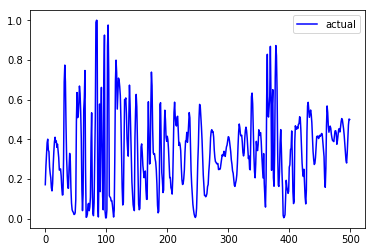

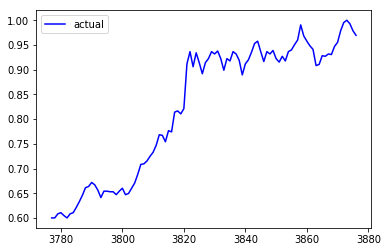

In [110]:

    
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
#print(df.head())
df_norm=normalize(df)
#X_train, Y_train = buildTrain(df_norm, 60, 5)
X_test = genInputTrain(df_norm,30,7)
result = model.predict(X_test)
#print(result[-40:])

print(result.shape)
print(X_test.shape)
plot_stock(result[-500:])
plot_stock(df['close'][-100:])

In [ ]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
accuracy(df,model,past=30,future=5,profit=0.03,threshold=0.2)

In [92]:
a=[1,2,41,3,4]
max(a)

41